In [563]:
using DifferentialEquations, KernelDensity, Plots, StatsBase

# for testing solve_prob_alpha_sigma
test_p = [-0.6, 0.1]
# for testing rep_solve
test_list_alpha, test_list_sigma = Array(range(-5., stop = 5.0, length = 11)), Array(range(-0., stop = 2.0, length = 5))
tspan = (0.0, 2.0)


function f(x, p, t) # neq
    dx = p[1]*x[1]-x[1]^3
    return [dx]
end

function g(x, p, t) # noiseeq
    dx = p[2]*x[1]
    return [dx]
end

test_prob_arg_list = [f, g, tspan];

In [564]:
function solve_prob_alpha_sigma_old(prob_arg_list, p_arg) # DO NOT TOUCH
    temp_f, temp_g, temp_tspan = prob_arg_list
    temp_p = p_arg
    temp_outputs = Float64[]
    initpoints = range(-1., stop = 1.0, length = 20)
    Npoints = 200
    timepoints = 0.2:0.2:2.0;
    for val in initpoints
        x0 = [val]
        temp_prob = SDEProblem(temp_f, temp_g, x0, temp_tspan, temp_p)
        for i in 1:Npoints    
            nsol = solve(temp_prob)
            append!(temp_outputs, collect(Iterators.flatten(nsol(timepoints))))
        end
    end
    return temp_outputs
end

solve_prob_alpha_sigma_old (generic function with 1 method)

In [565]:
function solve_prob_alpha_sigma_new(prob_arg_list, p_arg) # DO  TOUCH
    temp_f, temp_g, temp_tspan = prob_arg_list
    temp_p = p_arg
    initpoints = range(-5., stop = 5.0, length = 10) # keeping this low is good for performance
    Npoints = 20 # keeping this low is good for performance
    timepoints = 0.0:0.2:2.0 # changing stepsize doenst cost much but makes results smoother. changed start from 0.2 ( why was it 0.2 before?).
    temp_outputs = Array{Float64}(undef, length(initpoints)*Npoints*length(timepoints))
    for i in 1:length(initpoints)
        x0 = [initpoints[i]]
        temp_prob = SDEProblem(temp_f, temp_g, x0, temp_tspan, temp_p)
        for j in 1:Npoints    
            nsol = Array(solve(temp_prob, saveat = timepoints))
            temp_outputs[(i-1)*length(timepoints)*Npoints+(j-1)*length(timepoints)+1:(i-1)*length(timepoints)*Npoints+(j-1)*length(timepoints)+length(timepoints)] = nsol
        end
    end
    return temp_outputs
end

solve_prob_alpha_sigma_new (generic function with 1 method)

In [566]:
function rep_solve(prob_arg_list, list_alpha, list_sigma)
    outputs = Array{Array{Float64,1}}(undef,length(list_alpha),length(list_sigma))
    for i in range(1, stop = length(list_alpha))
        for j in range(1, stop = length(list_sigma))
            test_p =[list_alpha[i], list_sigma[j]]
            outputs[i, j] = solve_prob_alpha_sigma_new(test_prob_arg_list, test_p)
        end
    end
    return outputs
end

rep_solve (generic function with 1 method)

In [567]:
@time rep_output = rep_solve(test_prob_arg_list, test_list_alpha, test_list_sigma)
#first dim is alpha, second dim is sigma

 78.737674 seconds (1.35 G allocations: 122.635 GiB, 17.09% gc time)


11×5 Array{Array{Float64,1},2}:
 [-5.0, -0.797231, -0.278386, -0.101735, -0.0373939, -0.0137678, -0.00507328, -0.00189238, -0.000706685, -0.000269699  …  0.797231, 0.278386, 0.101735, 0.0373939, 0.0137678, 0.00507328, 0.00189238, 0.000706685, 0.000269699, 9.96331e-5]  …  [-5.0, -1.4755, -0.337095, -0.22167, -0.0137669, -0.00260097, -0.000486616, -8.01254e-5, -3.67441e-5, -1.1447e-5  …  0.681787, 0.285539, 0.0799227, 0.0513867, 0.0233408, 0.00649315, 0.000798088, 8.21578e-5, 1.85867e-5, 5.1099e-6]
 [-5.0, -0.918096, -0.381679, -0.169062, -0.0757511, -0.0340244, -0.0152948, -0.00687449, -0.00311399, -0.00140812  …  0.918096, 0.381679, 0.169062, 0.0757511, 0.0340244, 0.0152948, 0.00687449, 0.00311399, 0.00140812, 0.000634005]          [-5.0, -1.38364, -0.10586, -0.268662, -0.293369, -0.155884, -0.0280892, -0.00521163, -0.00192495, -0.000832101  …  1.33015, 0.415682, 0.0821001, 0.0448187, 0.0108661, 0.00202502, 0.000512631, 0.000318081, 0.000137129, 2.39872e-5]
 [-5.0, -1.05049, -0.514209,

In [568]:
function plot_rep_solve(outputs, list_alpha, list_sigma, alpha_start, alpha_end,  sigma_start, sigma_end, color_palette)
    p = plot(xlab = "x", ylab = "potential", grid = "off", legend = :outertopright, size = (1000,1100), palette = color_palette)
    for i in range(alpha_start, stop = alpha_end)
        for j in range(sigma_start, stop = sigma_end)
            kdx_1_N200 = kde(rep_output[i,j], bandwidth = 0.05)
            sup1 = plot!(-5.0:0.01:5.0, -log.(pdf(kdx_1_N200,-5.0:0.01:5.0).+1), # we added log shift
                    label = "$(test_list_alpha[i]), $(test_list_sigma[j])")
        end
    end
    return p
end

plot_rep_solve (generic function with 6 methods)

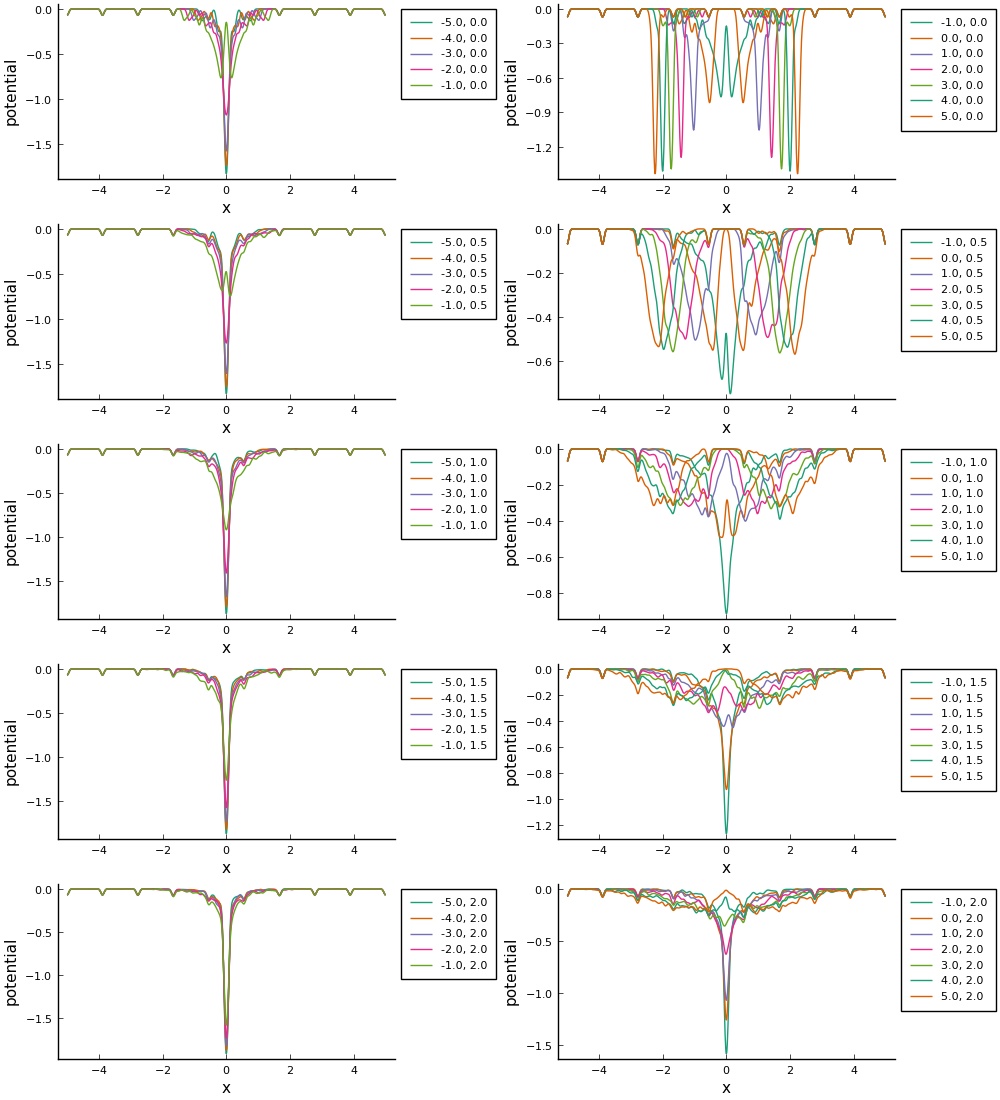

In [569]:
p1 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 5, length(test_list_alpha), 1, 1, :Dark2_5)
p2 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 1, 5, 1, 1, :Dark2_5)
p3 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 5, length(test_list_alpha), 2, 2, :Dark2_5)
p4 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 1, 5, 2, 2, :Dark2_5)
p5 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 5, length(test_list_alpha), 3, 3, :Dark2_5)
p6 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 1, 5, 3, 3, :Dark2_5)
p7 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 5, length(test_list_alpha), 4, 4, :Dark2_5)
p8 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 1, 5, 4, 4, :Dark2_5)
p9 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 5, length(test_list_alpha), 5, 5, :Dark2_5)
p10 = plot_rep_solve(rep_output, test_list_alpha, test_list_sigma, 1, 5, 5, 5, :Dark2_5)
p_app = plot(p2, p1, p4, p3, p6, p5, p8, p7,p10, p9, layout = (5, 2))

In [570]:
# Calculates the KS distance between two distributions (approximate)
function kolmogorov_smirnov_distance(data1::Array{Float64}, data2::Array{Float64})
            #Produce function which returns ecdf
            ecdf_func_1 = StatsBase.ecdf(data1)
            ecdf_func_2 = StatsBase.ecdf(data2)
            #find maximum value of both data sets for ecdf intervals
            max = maximum([data1;data2])
            intervals = max/999
            #calculate ecdf value at each interval
            ecdf_vals_1 = Array{Float64,1}(undef,1000)
            for i in 1:1000
                        ecdf_vals_1[i] = ecdf_func_1(intervals*(i-1))
            end
            ecdf_vals_2 = Array{Float64,1}(undef,1000)
            for i in 1:1000
                        ecdf_vals_2[i] = ecdf_func_2(intervals*(i-1))
            end
            dist = maximum(abs.(ecdf_vals_1 - ecdf_vals_2))
            return dist
end

kolmogorov_smirnov_distance (generic function with 1 method)

In [571]:
function KS_vectors(rep_output)
    res = Array{Float64}(undef,size(rep_output)[1],size(rep_output)[2])
    for i in 1:size(rep_output)[1]
        for j in 1:size(rep_output)[2]
            res[i,j] = kolmogorov_smirnov_distance(rep_output[i,1], rep_output[i,j]) 
        end
    end
    return res
end

KS_vectors (generic function with 1 method)

In [612]:
function plot_KS_vectors(KS_res, test_list_sigma, test_list_alpha)
    p1 = plot(grid = "off", ylab = "KS distance to lowest noise",size = (900,400),palette =:Dark2_5, xlab = "increasing stochastisity",  legend = :outertopright)
    for i in 1:Int(round(length(test_list_alpha)/2))
        temp_alpha = test_list_alpha[i]
        plot!(test_list_sigma, KS_res[i,:], label = "Alpha: $temp_alpha")
        scatter!(test_list_sigma, KS_res[i,:], label = "")
    end
    p2 = plot(grid = "off", ylab = "KS distance to lowest noise", size = (900,400),palette = :Dark2_5, xlab = "increasing stochastisity",  legend = :outertopright)
    for i in Int(round(length(test_list_alpha)/2)):size(KS_res)[1]
        temp_alpha = test_list_alpha[i]
        plot!(test_list_sigma, KS_res[i,:], label = "Alpha: $temp_alpha")
        scatter!(test_list_sigma, KS_res[i,:], label = "")
    end
    return p1,p2
end

plot_KS_vectors (generic function with 1 method)

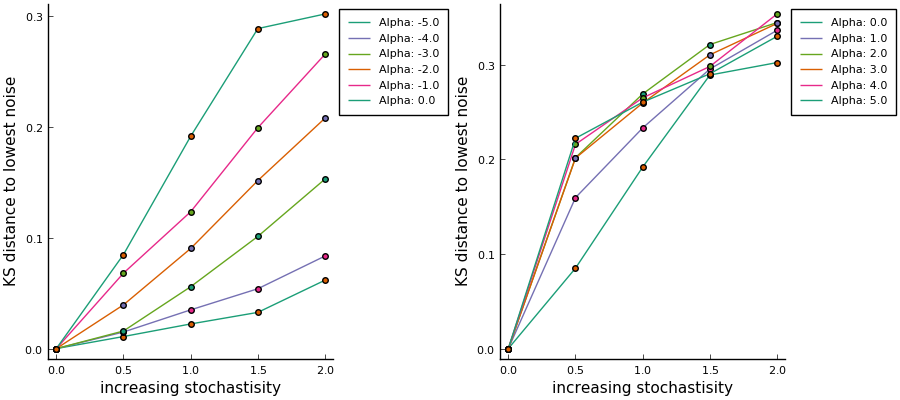

In [613]:
KS_res = KS_vectors(rep_output)
p = plot_KS_vectors(KS_res, test_list_sigma, test_list_alpha)
p_all =plot(p[1], p[2], layout=(1,2))